In [1]:
from sklearn.neural_network import MLPClassifier
import os
import numpy as np
import matplotlib.pyplot as plt
import pyod
from pyod.models.vae import VAE
import pickle

dir="Signal/"#<--- signal folder
filename="stop_01_p_p_to_t1_t1~0_26.7494500003_39HT1001l2j.npy" #<--- Signal file
sig0=np.load(dir+filename,allow_pickle=True)

dir="Background/" #<--- vg folder
filename="smHT1001l2j.npy" #<--- Background file
bg0=np.load(dir+filename,allow_pickle=True)

Using TensorFlow backend.


In [14]:
def normstdmax(ar):
    array=np.copy(ar)
    if array[0,-1]==0 or array[0,-1]==1:
        array[:,:-1]=array[:,:-1]-np.min(array[:,:-1],0)
        array[:,:-1]=array[:,:-1]/np.std(array[:,:-1],0)
        array[:,:-1]=array[:,:-1]/np.max(array[:,:-1])
        return array
    
    #Sker kun hvis ovenstående kriterie fejler.
    array=array-np.min(array,0)
    array=array/np.std(array,0)
    array=array/np.max(array)
    return array

In [4]:
#Adding signal and background into one randomly mixed array with a 0/1 at the end to identify background and signal
def full(sig,bg):
    full=np.row_stack((sig,bg))
    full=np.column_stack((full,np.row_stack((np.ones((sig.shape[0],1)),np.zeros((bg.shape[0],1))))))
    np.take(full,np.random.rand(full.shape[0]).argsort(),axis=0,out=full)
    return full

In [5]:
#Mix the ordering in case unknown sorting exists
np.random.seed(3)
np.take(sig0,np.random.rand(sig0.shape[0]).argsort(),axis=0,out=sig0)
np.take(bg0,np.random.rand(bg0.shape[0]).argsort(),axis=0,out=bg0)

array([[ 1.047494e+05,  2.767270e+04,  7.558890e-01, ...,  5.500950e+04,
        -1.499920e+00,  2.805900e+00],
       [ 1.849348e+05,  2.214660e+04, -1.726390e+00, ...,  8.346660e+04,
        -1.050830e-01, -2.920690e+00],
       [ 1.564298e+05,  3.187170e+04, -2.001100e+00, ...,  3.952210e+04,
         1.136310e+00,  1.962330e+00],
       ...,
       [ 3.662640e+05,  8.445130e+04, -2.763890e+00, ...,  1.822790e+04,
         1.698010e+00, -1.528990e+00],
       [ 5.033517e+05,  2.391250e+05, -1.390990e+00, ...,  7.290150e+04,
        -6.253440e-02, -1.254320e+00],
       [ 2.240684e+05,  1.176470e+05, -8.790790e-01, ...,  5.040980e+04,
        -6.348420e-02, -1.997450e-01]])

In [6]:
np.random.seed(3)

full0=full(sig0,bg0) #All signal and background

part0=np.size(sig0)/np.size(bg0) #Part that is signal

bg0h1=bg0[:int(np.shape(bg0)[0]/2)] #First half of background

bg0h2=bg0[int(np.shape(bg0)[0]/2):] #Second half of background

sig0h1=sig0[:int(np.shape(sig0)[0]/2)] #First half of singal

sig0h2=sig0[int(np.shape(sig0)[0]/2):] #SEcond half of signal


full0h1=full(sig0h1,bg0h1) #First half of bg and sig

full0h2=full(sig0h2,bg0h2) #Second half of bg and sig



bgpart0=bg0[::1] #<-- Determine how much og bg and sig to use
#bg100t0=bg0[::30]
#sig100t0=sig0[::15]
sigpart0=sig0[:] #<-- Determine how much og bg and sig to use
#bg100t0=bg0[::6]
#sig100t0=sig0[::6]
fullpart0=full(sigpart0,bgpart0)

#Splitting chosen part of data in two and appending into signal+bg (full).
bgpart0h1=bgpart0[:int(np.shape(bgpart0)[0]/2)]
bgpart0h2=bgpart0[int(np.shape(bgpart0)[0]/2):]
sigpart0h1=sigpart0[:int(np.shape(sigpart0)[0]/2)]
sigpart0h2=sigpart0[int(np.shape(sigpart0)[0]/2):]
fullpart0h1=full(sigpart0h1,bgpart0h1)
fullpart0h2=full(sigpart0h2,bgpart0h2)

In [7]:
np.shape(bgpart0)

(3188321, 12)

In [15]:
bgpart0h2normstdmax=normstdmax(bgpart0h2)
fullpart0h1normstdmax=normstdmax(fullpart0h1)
fullpart0h2normstdmax=normstdmax(fullpart0h2)

In [16]:
def VAEfitgaml2(train,test,encoders=[9],decoders=[9],contam=0.01,name="VAE",epochs=1,lat=1,outact='sigmoid',stdz=False,gam=1,l2=0.1,drop=0.2,sz=32):
    # By mistake taking 1 mio. events
    clf_name = name
    clf = VAE(contamination=contam,encoder_neurons=encoders,decoder_neurons=decoders,epochs=epochs,latent_dim=lat, output_activation=outact, preprocessing=stdz,gamma=gam,l2_regularizer=l2,dropout_rate=drop,batch_size=sz)#
    clf.fit(train)
    
    score = clf.decision_function(test)  # outlier scores
    
    return score, clf
    
    #trainingset, testset, encoder neurons, decoder neurons, not important, name, epochs, latent space size, output activation function(see tf activation functions), whether to use automatic standardization, gamma-parameter, l2-regularizer, dropout percentage, batch size.

In [17]:
def roccurve(signal,total,scoretruth,N=100,lin=True,log=False,rev=False):
    #signal, full, [score, truthvalue], points in roc curve, linear plot, log-plot, reverse roc curve.
    scoretruth=scoretruth[((-1)**(rev)*scoretruth[:,0]).argsort()]
    nsig=np.shape(signal)[0]
    ntot=np.shape(total)[0]
    nbg=ntot-nsig
    isig=0
    ibg=0
    j=0
    sigar=[]
    bgar=[]
    
    for i in range(ntot):
        
        if scoretruth[ntot-i-1,1]==1:
            isig+=1
            if isig/nsig>j/N:
                j=j+1
                sigar+=[isig]
                bgar+=[ibg]
            if isig==nsig:
                break
                
        else:
            ibg+=1
    
    sigar+=[isig]
    bgar+=[ibg]
    
    sigar=np.array(sigar)/nsig
    bgar=np.array(bgar)/nbg
    
    if lin==True:
        plt.plot(sigar,bgar,"-")
        plt.xlabel("True positive rate")
        plt.ylabel("False positive rate")
        plt.show()
    
    if log==True:
        plt.plot(sigar,bgar,"-")
        plt.xlabel("True positive rate")
        plt.ylabel("False positive rate")
        plt.yscale('log')
        plt.show()
    
    score=sigar.dot(bgar)/N
    print("score:",score,"score2:",sum(bgar)*(sigar[1]-sigar[0]))
    print("50% signal gives:",bgar[int(N/2)],"90% signal gives:", bgar[int(N*0.9)])
    #print(bgar)
    return (sum(bgar)*(sigar[1]-sigar[0]))


In [22]:
def MLPfit(Data,Truth,Test,alpha=10**-4,layers=(5,5),verb=True):
    #full (without truth collumn), Truth-value,test data, l2-regularizer, number of neurons, verbocity
    clf = MLPClassifier(solver='adam', alpha=alpha, hidden_layer_sizes=layers, random_state=1,verbose=verb,tol=10**-4)
    clf.fit(Data, Truth)
    return clf.predict(Test), clf.predict_proba(Test), clf

In [19]:
def Normplot(full,scores,min=False,max=False,n=100,part=0.0001):
    #full, scores, min bound, max bound, number of bins, ignore margain to avoid plotting unnecessarily long tails.
    if min==False:
        min=np.min(scores)
    if max==False:
        max=np.max(scores)
        
    plt.figure(figsize=(15,10))
    bins=np.linspace(min,max,n)
    binwidth=(max+min)/n
    binedges=np.linspace(min-binwidth,max+binwidth,n+1)
    bgTr=full[:,-1]==0
    sigTr=full[:,-1]==1
    histbg,edges=np.histogram(scores[bgTr],binedges)
    histsig,edges=np.histogram(scores[sigTr],binedges)
    
    #histbg=hist[bgTr]
    erbg=np.sqrt(histbg)
    erbg=erbg/np.sum(histbg)
    histbg=histbg/np.sum(histbg)
    #histsig=hist[sigTr]
    ersig=np.sqrt(histsig)
    ersig=ersig/np.sum(histsig)
    histsig=histsig/np.sum(histsig)
    
    partsum=0
    if part>0:         
        for i in range(len(histbg)):
            partsum+=histbg[-i]
            if partsum>=part:
                histsig=histsig[:-i]
                histbg=histbg[:-i]
                bins=bins[:-i]
                erbg=erbg[:-i]
                ersig=ersig[:-i]
                break


    plt.bar(bins,histbg,yerr=erbg,label="Background",width=(binedges[-1]-binedges[0])/n,alpha=0.5,color="green")
    plt.bar(bins,histsig,yerr=ersig,label="Signal",width=(binedges[-1]-binedges[0])/n,alpha=0.3,color="red")
    plt.legend(fontsize='xx-large')
    plt.title("score",fontsize='xx-large')
    plt.xlabel("score",fontsize='xx-large')
    plt.ylabel("counts(normalized)",fontsize='xx-large')
    plt.show()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 12)           0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 12)           156         input_1[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 12)           156         dense_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 12)           0           dense_2[0][0]                    
____________________________________________________________________________________________

/groups/hep/mthomsen/miniconda3/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output model_2 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to model_2.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 1434744 samples, validate on 159417 samples
Epoch 1/3
1434744/1434744 [==============================] - 34s 24us/step - loss: 0.0174 - val_loss: 0.0080
Epoch 2/3
1434744/1434744 [==============================] - 34s 24us/step - loss: 0.0070 - val_loss: 0.0064
Epoch 3/3
1434744/1434744 [==============================] - 34s 24us/step - loss: 0.0063 - val_loss: 0.0062


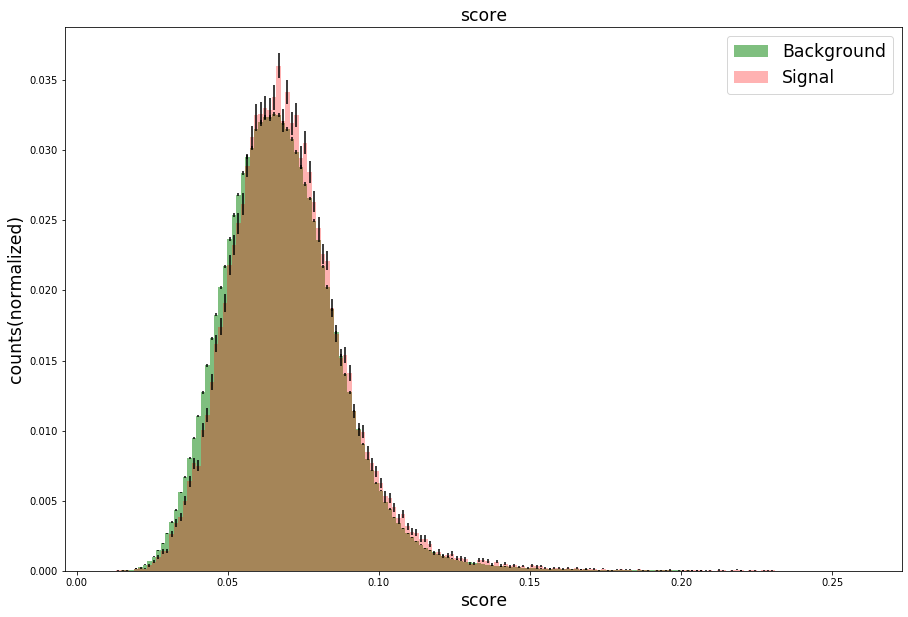

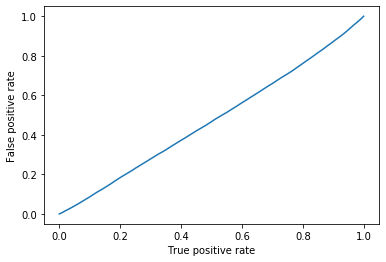

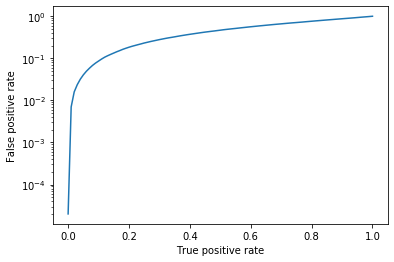

score: 0.32330179887196947 score2: 0.4776597052739562
50% signal gives: 0.46658679179003365 90% signal gives: 0.8718654338334922


0.4776597052739562

In [20]:
score, clf=VAEfitgaml2(bgpart0h2normstdmax,fullpart0h1normstdmax[:,:-1],encoders=[12,4],decoders=[4,12],lat=3,epochs=3, stdz=False,gam=10**(-6),l2=10**(-6),drop=0,sz=60)#<--- choose parameters (see function)
#score is the outlier score, clf is the trained model
Normplot(fullpart0h1,score,n=600)
roccurve(fullpart0h1[fullpart0h1[:,-1]==1,:-1],fullpart0h1[:,:-1],np.column_stack((score,fullpart0h1[:,-1])),N=100,log=True)
dir1="results/" #<--- Choose save folder name
np.save(dir1+"VAEres1.npy", np.column_stack((fullpart0h1,score)))#<--- choose result name

Iteration 1, loss = 0.12767804
Iteration 2, loss = 0.12350455
Iteration 3, loss = 0.12302054
Iteration 4, loss = 0.12271247
Iteration 5, loss = 0.12219132
Iteration 6, loss = 0.12131599
Iteration 7, loss = 0.12035710
Iteration 8, loss = 0.11941613
Iteration 9, loss = 0.11865795
Iteration 10, loss = 0.11822830
Iteration 11, loss = 0.11786541
Iteration 12, loss = 0.11753990
Iteration 13, loss = 0.11733619
Iteration 14, loss = 0.11713381
Iteration 15, loss = 0.11693332
Iteration 16, loss = 0.11680495
Iteration 17, loss = 0.11666704
Iteration 18, loss = 0.11654666
Iteration 19, loss = 0.11648654
Iteration 20, loss = 0.11637571
Iteration 21, loss = 0.11625621
Iteration 22, loss = 0.11616082
Iteration 23, loss = 0.11607464
Iteration 24, loss = 0.11599518
Iteration 25, loss = 0.11595919
Iteration 26, loss = 0.11591666
Iteration 27, loss = 0.11578529
Iteration 28, loss = 0.11577871
Iteration 29, loss = 0.11572824
Iteration 30, loss = 0.11566268
Iteration 31, loss = 0.11564464
Iteration 32, los

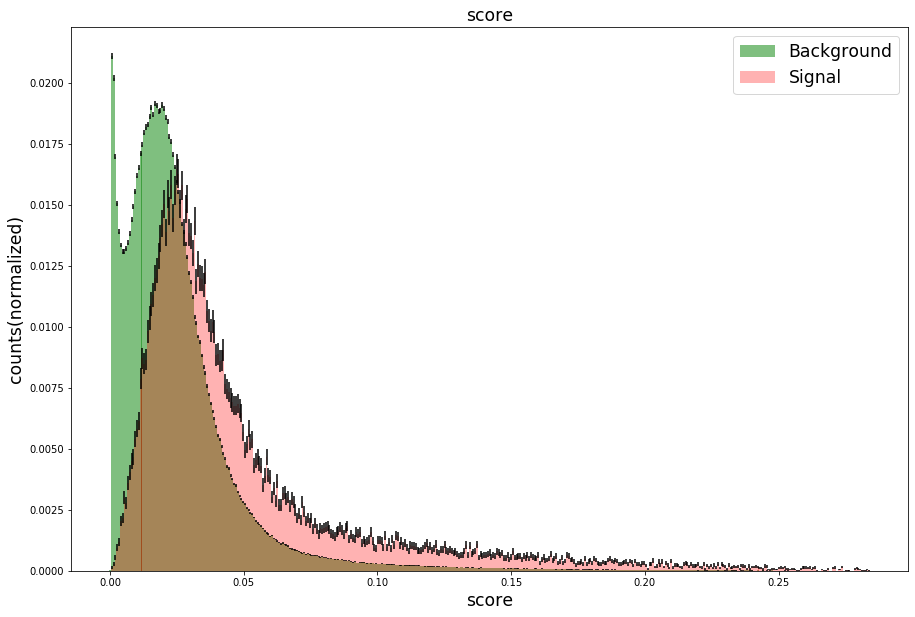

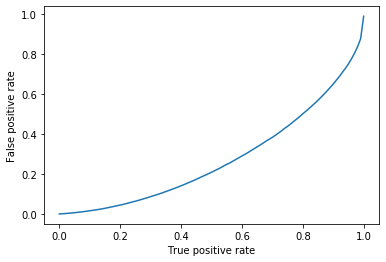

score: 0.208959626162371 score2: 0.27864299540710846
50% signal gives: 0.20805126210668942 90% signal gives: 0.6487291112560847


0.27864299540710846

In [23]:
pred,score,clf=MLPfit(fullpart0h2normstdmax[:,:-1],fullpart0h2normstdmax[:,-1],fullpart0h1normstdmax[:,:-1],alpha=10**-(4),layers=(24,24,12),verb=True)
Normplot(fullpart0h1,score[:,1],max=np.max(score[:,1]),n=600)
roccurve(fullpart0h1[fullpart0h1[:,-1]==1,:-1],fullpart0h1[:,:-1],np.column_stack((score[:,1],fullpart0h1[:,-1])),N=100)
dir1="results/" #<--- Choose save folder name
np.save(dir1+"MLPres1.npy", np.column_stack((fullpart0h1,score[:,1])))#<--- choose result name